# Matching the WEST ICRH Antenna

In this notebook we investigate the various method to match a WEST ICRH antenna. By matching the antenna we mean to find 4 capacitances values $C_1$, $C_2$, $C_3$ and $C_4$ in order for the antenna to be operated at a given frequency $f_0$. 

In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np
import sys
from tqdm.notebook import tqdm 
sys.path.append('..')
rf.stylely()

C:\Users\JH218595\Documents\scikit-rf\skrf\plotting.py:1441: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  mpl.style.use(os.path.join(pwd, style_file))


In [5]:
from west_ic_antenna import WestIcrhAntenna

## Matching Each Sides Separately
Here, each side of the antenna is matched separatly, which leads to two set of capacitances $(C_1, C_2)$ and $(C_3,C_4)$.

In the following example, both sides of the antenna are matched at the frequency $f_0$, keeping opposite side unmatched (C=150pF):

In [6]:
f0 = 55e6
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

In [7]:
C_match_left = ant.match_one_side(f_match=f0, side='left', solution_number=1)
C_match_right = ant.match_one_side(f_match=f0, side='right', solution_number=1)
print('Left side matching point: ', C_match_left)
print('Right side matching point: ', C_match_right)

True solution #1: [50.75831986 48.74412505]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.56074454 48.9336573 ]
Left side matching point:  [50.75831986188321, 48.744125053808496, 150, 150]
Right side matching point:  [150, 150, 50.56074453950816, 48.933657300373305]


Let's have a look to the RF reflection coefficient of each sides:

<IPython.core.display.Javascript object>


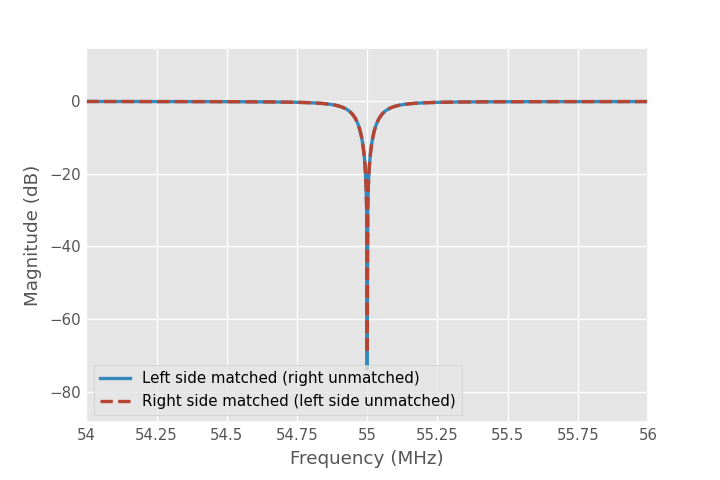

In [8]:
fig, ax = plt.subplots()
ant.circuit(Cs=C_match_left).network.plot_s_db(m=0, n=0, lw=2, ax=ax)
ant.circuit(Cs=C_match_right).network.plot_s_db(m=1, n=1, lw=2, ls='--', ax=ax)
ax.legend(('Left side matched (right unmatched)', 
           'Right side matched (left side unmatched)'))

In reality, the precision at which one can tune the capacitance is not better than 1/100 pF, so one have to consider rounding optimal solutions to such precision :


In [9]:
C_match_left = ant.match_one_side(f_match=f0, side='left', 
                                  solution_number=1, decimals=2)
C_match_right = ant.match_one_side(f_match=f0, side='right', 
                                   solution_number=1, decimals=2)
print('Left side matching point: ', C_match_left)
print('Right side matching point: ', C_match_right)

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.75832059 48.74412242]
Rounded result: [50.76, 48.74, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [38.69061366 12.        ]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.56074494 48.9336565 ]
Rounded result: [150.0, 150.0, 50.56, 48.93]
Left side matching point:  [50.76, 48.74, 150.0, 150.0]
Right side matching point:  [150.0, 150.0, 50.56, 48.93]


Note that the performances are slightly degraded, but, it's real life! 

<IPython.core.display.Javascript object>


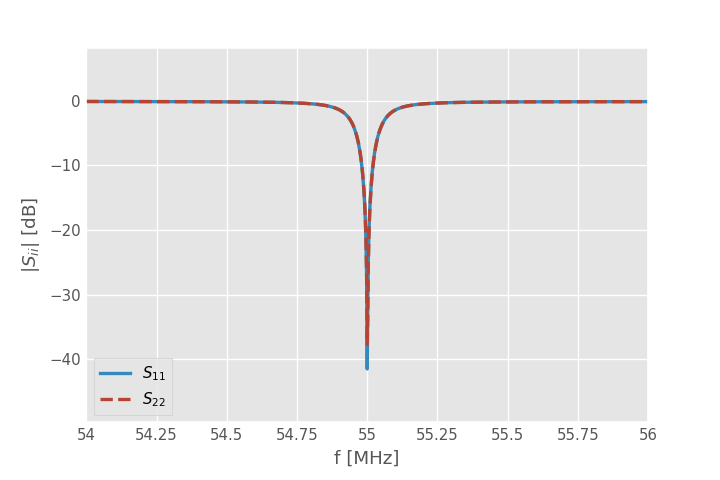

In [10]:
fig, ax = plt.subplots()
ant.circuit(Cs=C_match_left).network.plot_s_db(m=0, n=0, lw=2, ax=ax)
ant.circuit(Cs=C_match_right).network.plot_s_db(m=1, n=1, lw=2, ls='--', ax=ax)
ax.legend(('Left side matched (right unmatched)', 
           'Right side matched (left side unmatched)'))
ax.set_ylabel('$|S_{ii}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{11}$', '$S_{22}$'))

## Frequency Shift for Dipole Excitation
The coupling between antenna's sides requires shifting the frequency with respect to the matching frequency used for each side separately. Dipole excitation requires to shift the frequency to higher frequency to operate the antenna in a optimal conditions:

In [11]:
# dipole excitation
power = [1, 1]
phase = [0, rf.pi]
# combine both separate solutions
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_match)
# finding the optimum frequency
idx_f_opt = np.argmin(np.abs(s_act[:,0]))
f_opt = freq.f[idx_f_opt]
delta_f = f_opt - f0
print(f'Optimum frequency is f_opt={f_opt/1e6} MHz {delta_f/1e6} MHz shift' )

Optimum frequency is f_opt=55.212 MHz 0.212 MHz shift


<IPython.core.display.Javascript object>


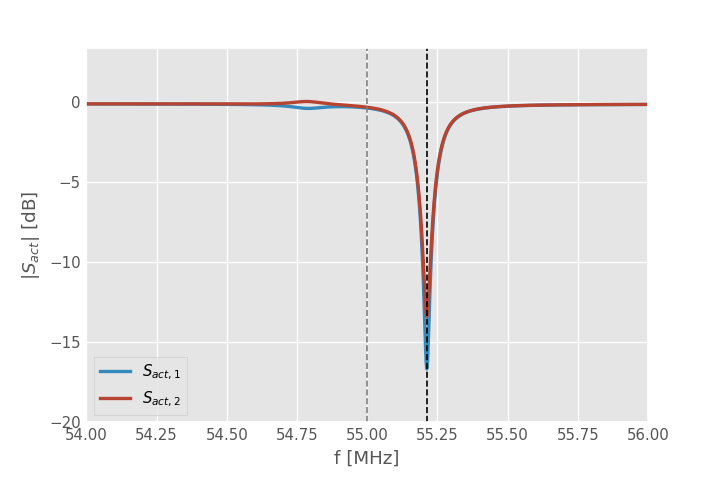

In [12]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.axvline(f_opt/1e6, ls='--', color='k')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))

In [13]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')